# US Institutions Financial Report

In [18]:
# May need to install libraries directly in Jupyter notebook with the following commands
#! pip3 install --user pandas
#! pip3 install --user psycopg
#! pip3 install --user matplotlib
import pandas as pd
import psycopg
from matplotlib import pyplot as plt
from credentials import DBNAME, HOST, USERNAME, PASSWORD

In [35]:
# Parameters
YEAR = 2021


In [36]:
# Set the connection and grab the data from SQL
YEAR = str(YEAR) + '-01-01 00:00:00'

# Connect to the database using parameters from credentials.py
conn = psycopg.connect(
    dbname=DBNAME,
    host=HOST,
    user=USERNAME,
    password=PASSWORD)

# Create a cursor and use it to submit/execute a query:
cur = conn.cursor()

select_cmd = """
    SELECT * FROM institutions 
    WHERE extracted_year = %s;
"""

all_select_cmd = """
    SELECT * FROM institutions 
    WHERE extracted_year <= %s;
"""

# Save to a dataframe
df = pd.DataFrame(cur.execute(select_cmd, (YEAR,)))
all_df = pd.DataFrame(cur.execute(all_select_cmd, (YEAR,)))
colnames =['pkey', 'opeid', 'name', 'address', 'latitude',
            'longitude', 'fips', 'region', 'ccbasic', 'cbsa', 
            'csa', 'accreditor', 'pred_degree', 'highest_degree',
            'control', 'admission_rate', 'in_state_tuit', 'out_state_tuit',
            'prog_year_tuit', 'revenue_tuit', 'two_yr_default',
            'three_yr_default', 'avg_faculty_salary', 'sat_avg', 
            'prop_loan', 'extracted_year', 'zip', 'city', 'state']
df.columns = colnames
all_df.columns = colnames

# Close the connection
cur.close()
conn.close()

# Data Summary

# Summary of Current College Tuition Rates

# Best and Worst Performing Institutions by Loan-Repayment Rates

We will sort our data by the three year default variable, which measures loan repayment rates. The best performing universities have the lowest default rates, and the worst have the highest rates. Below is a table displaying the best and worst performing institutions in the specified year.

In [37]:
# Filter out rows with None or NaN in 'name' and 'three_yr_default'
df_filtered = df.dropna(subset=['name', 'three_yr_default'])
df_filtered = df_filtered[df_filtered['name'] != 'None']

# Extract the bottom 10 institutions
worst_performing = df_filtered.sort_values(by='three_yr_default').tail(10)

# Extract the top 10 institutions
best_performing = df_filtered.sort_values(by='three_yr_default').head(10)

best_performing_output = best_performing.loc[:, ['name', 'three_yr_default']]
worst_performing_output = worst_performing.loc[:, ['name', 'three_yr_default']]

print("Top 10 Best-Performing Institutions:")
print(best_performing_output)

print("\nBottom 10 Worst-Performing Institutions:")
print(worst_performing_output)

Top 10 Best-Performing Institutions:
                                                   name  three_yr_default
2463                            Surry Community College               0.0
2132      Pomeroy College of Nursing at Crouse Hospital               0.0
1288                    Baton Rouge School of Computers               0.0
4018       School of Automotive Machinists & Technology               0.0
5032  Pontifical John Paul II Institute for Studies ...               0.0
5031                        Institute of World Politics               0.0
1287  Baton Rouge General Medical Center School of N...               0.0
2152                                 CUNY School of Law               0.0
2154  CVPH Medical Center School of Radiologic Techn...               0.0
2160                         Belanger School of Nursing               0.0

Bottom 10 Worst-Performing Institutions:
                                                   name  three_yr_default
5879                       Kenny'

In [5]:
# Can export to a PDF if desired
# OPTIONAL: don't need to run
# best_performing[['name', 'three_yr_default']].to_csv('data/best_performing_institutions.csv', index=False)
# worst_performing[['name', 'three_yr_default']].to_csv('data/worst_performing_institutions.csv', index=False)

# Tuition and Loan Repayment Rates

How have tuition rates and loan repayment rates changed over time for the top 100 most expensive universities in the U.S.?
We will explore this by first finding the top 100 most expensive schools in the specified year.

In [39]:
# First find the top 100 most expensive schools
# Find most expensive out of:
# (in_state_tuit + out_state_tuit)/2, or the average tuition cost

df['avg_tuition'] = (df['in_state_tuit'] + df['out_state_tuit']) / 2

df_sorted = df.sort_values(by='avg_tuition', ascending=False)

top_100 = df_sorted.head(100)

Below is a graph of these schools showing their tuition and loan repayment rates.

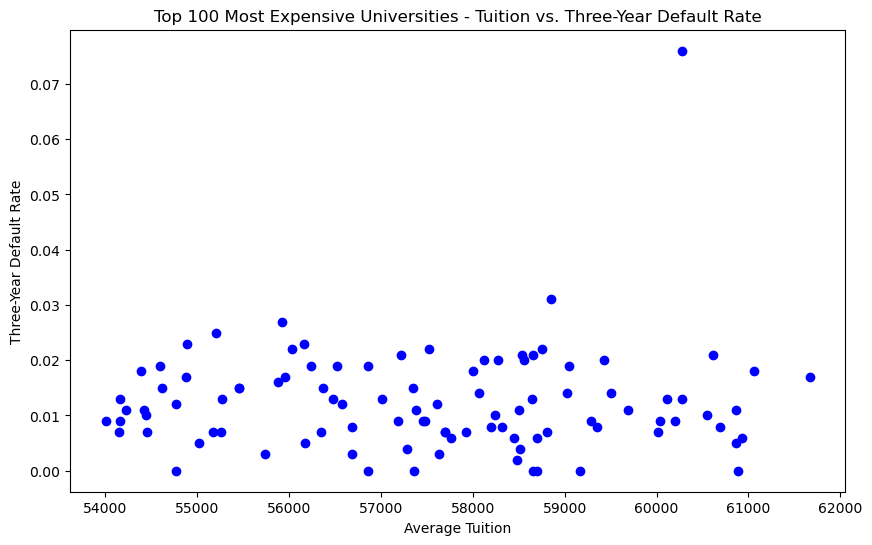

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(top_100['avg_tuition'], top_100['three_yr_default'], color='blue')
plt.title('Top 100 Most Expensive Universities - Tuition vs. Three-Year Default Rate')
plt.xlabel('Average Tuition')
plt.ylabel('Three-Year Default Rate')
plt.show()

# Relationship between average tuition and revenue tuition and SAT score

Are “smarter” colleges more expensive? Below, we have plots of the average tuition vs. SAT score as well as the revenue tuition vs. SAT score for institutions of the specified year.

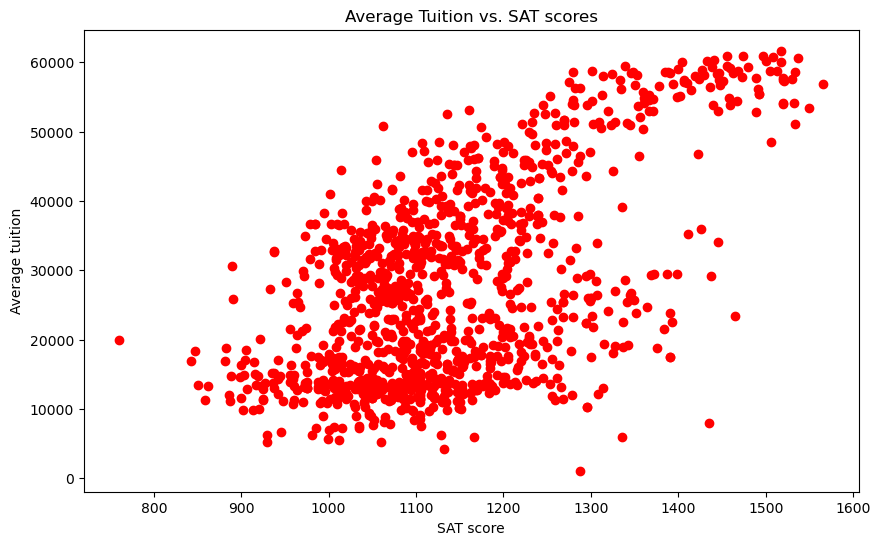

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(df['sat_avg'], df['avg_tuition'], color='red')
plt.title('Average Tuition vs. SAT scores')
plt.xlabel('SAT score')
plt.ylabel('Average tuition')
plt.show()

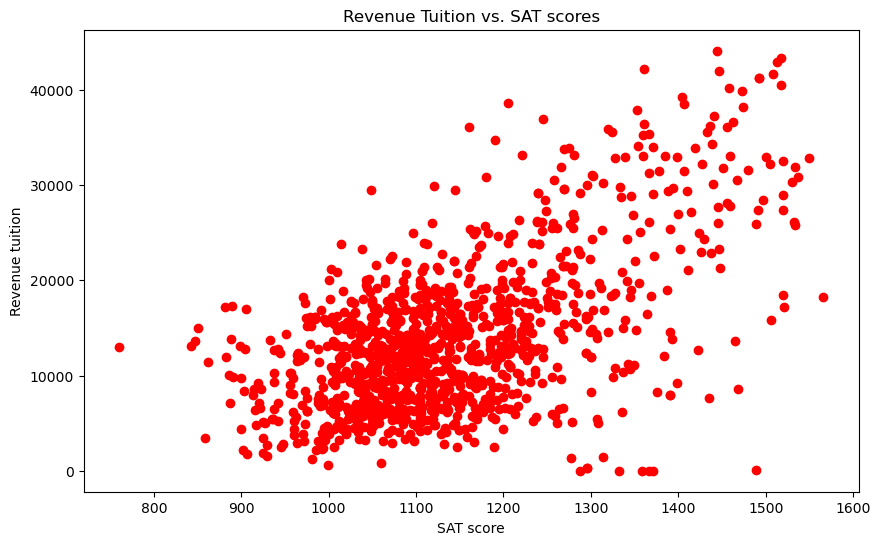

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(df['sat_avg'], df['revenue_tuit'], color='red')
plt.title('Revenue Tuition vs. SAT scores')
plt.xlabel('SAT score')
plt.ylabel('Revenue tuition')
plt.show()

# SAT Scores and College Admission Rate

# Faculty Salary and Revenue Tuition

In [43]:
average_rev_tuit_by_state = pd.DataFrame(df.groupby('state')['revenue_tuit'].mean())
df_sorted_rev = df.sort_values(by='revenue_tuit', ascending=False)
top_10 = df_sorted_rev.head(10)

In [44]:
average_salary_fac = df.copy()
average_salary_fac.groupby('state')
average_salary_fac.dropna()
df_sorted_fac = average_salary_fac.sort_values(by='avg_faculty_salary', ascending=False)
top_10 = df_sorted_fac.head(10)


In [12]:
#plt.figure(figsize=(10, 6))
#plt.hist(average_salary_fac['state'], bins=2)
#plt.title('Average Faculty by State')
#plt.xlabel('State')
#plt.ylabel('Average Monthly Faculty Salary')
#plt.show()

Relationship between average faculty salary and revenue tuition, which will show the relationship and contrast between how much students pay and how much faculties get paid. 

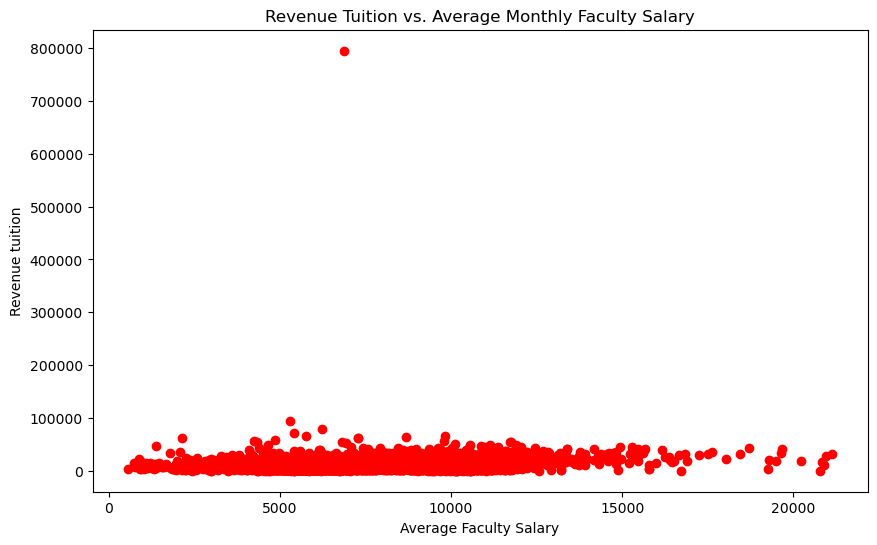

In [45]:
plt.figure(figsize=(10, 6))
plt.scatter(df['avg_faculty_salary'], df['revenue_tuit'], color='red')
plt.title('Revenue Tuition vs. Average Monthly Faculty Salary')
plt.xlabel('Average Faculty Salary')
plt.ylabel('Revenue tuition')
plt.show()

We seperate between public and private schools to see the difference between them. 

In [46]:
private_public = df.copy()
private_public.groupby('control')['avg_faculty_salary'].mean()

control
Private For-Profit    5301.538348
Private Non-Profit    7130.431302
Public                7798.634356
Name: avg_faculty_salary, dtype: float64

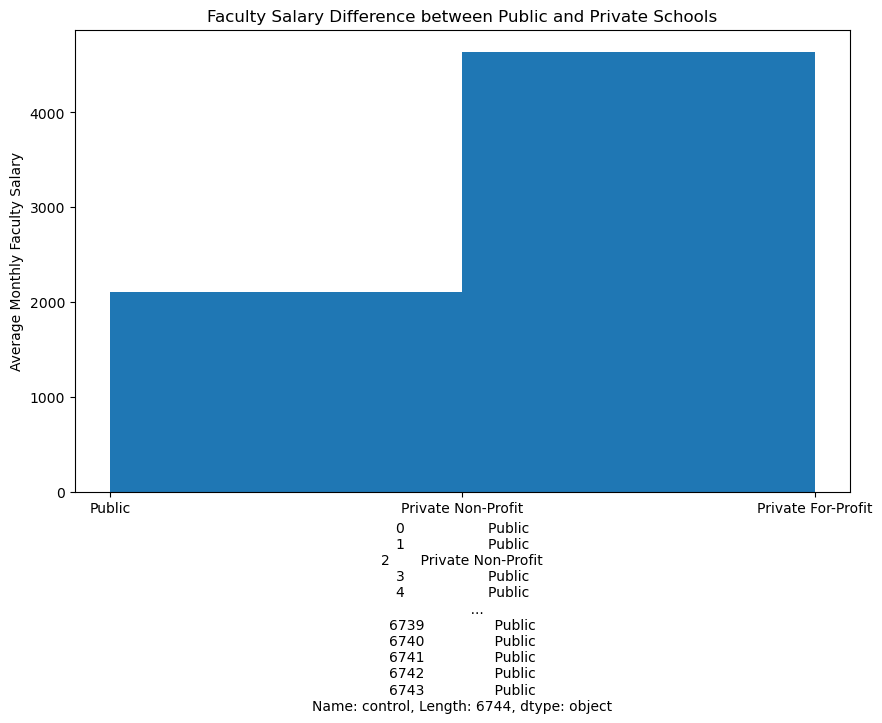

In [47]:
plt.figure(figsize=(10, 6))
plt.hist(private_public['control'], bins=2)
plt.title('Faculty Salary Difference between Public and Private Schools')
plt.xlabel(private_public['control'])
plt.ylabel('Average Monthly Faculty Salary')
plt.show()